# <center>Xgboost GridSearch

In [1]:
import os
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta

In [3]:
# import warnings
# warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

In [4]:
data_path = Path("data")
model_path = Path("model_data")

### data

In [5]:
example_predictions_name = "example_predictions.pkl"
test_features_name = "test_features.pkl"
train_features_name = "train_features.pkl"
train_outcomes_name = "train_outcomes.pkl"

In [173]:
example_predictions = pd.read_pickle(data_path / example_predictions_name)

In [6]:
test_features = pd.read_pickle(data_path / test_features_name)
train_features = pd.read_pickle(data_path / train_features_name)
train_outcomes = pd.read_pickle(data_path / train_outcomes_name)

In [7]:
test_features.shape, train_features.shape, train_outcomes.shape

((627908, 32), (2106808, 32), (2106808, 1))

In [8]:
from dataprocessing.process import StandardScaler, SmartLogtransformer, TrainTestSplit, Pipeline
from dataprocessing.impute import SimpleImputer

In [9]:
train_test_split = TrainTestSplit(test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_outcomes)

### Pipeline for data processing

In [10]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")), 
        ("logtransformer", SmartLogtransformer()), 
        ("scaler", StandardScaler())
    ]
)
pipe

[(imputer, <dataprocessing.impute.SimpleImputer>), 
(logtransformer, <dataprocessing.process.SmartLogtransformer>), 
(scaler, <dataprocessing.process.StandardScaler>)]

In [11]:
%%time
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(test_features)

Wall time: 5.22 s


## <center>XGBOOST

# <center>Parameters Tuning

## GridSearchXgb

In [12]:
import xgboost as xgb

#### Setting Parameters

In [13]:
from dataprocessing.process import GridSearchXgb

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [15]:
evals = [(dtrain, 'train'), (dval, 'eval')]

In [47]:
params = dict(
    objective = 'binary:logistic', 
    eval_metric = 'error'
)

In [48]:
xgb_train_params = dict(
    params = params, 
    dtrain = dtrain, 
    num_boost_round = 100, 
    evals = evals, 
    early_stopping_rounds=3, 
    verbose_eval=False
)

In [49]:
param_grid_total = dict(
    eta = [0.01, 0.05, 0.1, 0.5, 1, 2, 3],
    max_depth = range(3, 10),
    min_child_weight = range(1, 8), 
    subsample = [0.5, 1], 
    colsample_bytree = [0.5, 1], 
    alpha = [0.3, 0.65, 1]
)

In [50]:
def params_tunning(param_grid_total):
    for param in param_grid_total:
        param_grid = {param: param_grid_total[param]}
        search = GridSearchXgb(
            xgb_train_params = xgb_train_params,
            param_grid = param_grid,
        )
        search.fit()
        print(f"best_params: {search.best_params_}, best score: {search.best_score_}, best num round: {search.best_num_boost_round}")
        # set params
        for key in search.best_params_:
            params[key] = search.best_params_[key]
    return search.best_score_, params

In [51]:
best_score, best_params = params_tunning(param_grid_total)

best_params: {'eta': 0.1}, best score: 0.407981, best num round: 8
best_params: {'max_depth': 5}, best score: 0.407465, best num round: 10
best_params: {'min_child_weight': 1}, best score: 0.407465, best num round: 10
best_params: {'subsample': 0.5}, best score: 0.407168, best num round: 13
best_params: {'colsample_bytree': 1}, best score: 0.407168, best num round: 13
best_params: {'alpha': 1}, best score: 0.406794, best num round: 14


In [52]:
best_score

0.406794

In [53]:
print("best accuracy:", 1 - best_score)

best accuracy: 0.593206


In [54]:
best_params

{'objective': 'binary:logistic',
 'eval_metric': 'error',
 'eta': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.5,
 'colsample_bytree': 1,
 'alpha': 1}

In [89]:
bst.best_ntree_limit

14

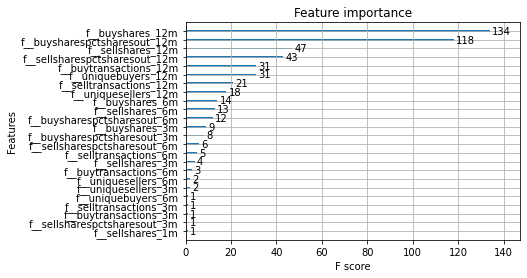

In [191]:
xgb.plot_importance(bst);

## <center>calibration_curve

In [158]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

In [159]:
bst = xgb.train(**xgb_train_params)

In [160]:
y_val_proba = bst.predict(dval, ntree_limit=bst.best_ntree_limit)

In [161]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_val.values, y_val_proba, n_bins=10)

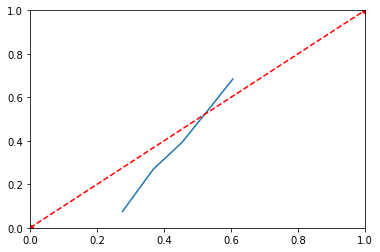

In [162]:
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot(range(0, 2), range(0, 2), 'ro--')
plt.xlim(0, 1)
plt.ylim(0, 1);

In [163]:
print("Brier score losses: (the smaller the better)")
clf_brier_score = brier_score_loss(y_val.values, y_val_proba)
print("No calibration: %1.3f" % clf_brier_score)

Brier score losses: (the smaller the better)
No calibration: 0.240


### Calibrating of Classifier
(CalibratedClassifierCV)

In [164]:
sk_best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error', 
    'n_estimators': bst.best_ntree_limit, 
     'learning_rate': 0.1,
     'max_depth': 5,
     'min_child_weight': 1,
     'subsample': 0.5,
     'colsample_bytree': 1,
     'reg_alpha': 1
}

In [165]:
clf = xgb.XGBClassifier(use_label_encoder=False, **sk_best_params)
clf.fit(X_train.values, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=14, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=1, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [166]:
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv="prefit", method='isotonic')

In [167]:
calibrated_clf.fit(X_val.values, y_val.values)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    eval_metric='error',
                                                    gamma=0, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints='',
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=5,
                                                    min_child_weight=1,
                                                    missing=nan,
 

In [168]:
calibrated_clf.score(X_val, y_val)

0.5953397476855131

In [169]:
y_val_proba_clbr = calibrated_clf.predict_proba(X_val.values)

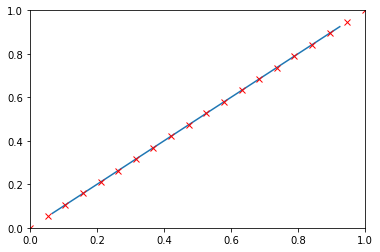

In [170]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_val.values, y_val_proba_clbr[:, 1], n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), 'rx')
plt.xlim(0, 1)
plt.ylim(0, 1);

In [172]:
clf_brier_score = brier_score_loss(y_val.values, y_val_proba_clbr[:, 1])
print("Isotonic calibration: %1.3f" % clf_brier_score)

Isotonic calibration: 0.237


## Submit

In [176]:
def make_submit(sk_clf, test_features, pipe, col_name="g__12m_binary"):
    X_test = pipe.transform(test_features)
    y_test_proba = sk_clf.predict_proba(X_test.values)
    df_y_test_proba = pd.DataFrame({col_name: y_test_proba[:, 1]}, index=X_test.index)
    return df_y_test_proba

In [177]:
test_xgb_submit = make_submit(calibrated_clf, test_features, pipe)

In [178]:
test_xgb_submit

g__12m_binary
date       tradingitemid               
2016-01-01 2585893             0.603191
           2585895             0.522619
           2586016             0.603814
           2586068             0.448502
           2586084             0.522619
...                                 ...
2019-09-20 633841867           0.359291
           634751265           0.354011
           635766194           0.354011
           636344928           0.354011
           637117468           0.354011

[627908 rows x 1 columns]

In [179]:
test_xgb_submit.to_pickle(data_path / "test_xgb_submit.pkl")

#### save-read check

In [189]:
test_xgb_submit_ = pd.read_pickle(data_path / "test_xgb_submit.pkl")
assert (test_xgb_submit_ == test_xgb_submit).all().item()

In [190]:
example_predictions

g__12m_binary
date       tradingitemid               
2006-12-29 2585893             0.541588
           2585895             0.522537
           2585941             0.500847
           2585945             0.496815
           2585957             0.552594
...                                 ...
2015-12-25 586093745           0.396823
           606023847           0.396823
           607745150           0.396823
           610592433           0.396823
           618650356           0.396823

[1618127 rows x 1 columns]